# 데이터셋 변환  
  
머신러닝이나 딥러닝에서 학습 데이터는 매우 중요하다.  
그래서 이번장은 데이터셋을 변환(데이터전처리,차원축소,특징추출..)하는 사이킷 런에서 제공하는 기능을 살펴보겠다.  
변환 객체도 fit(), transform() 함수를 제공한다. 
  

# 1. 파이프라인  
  
여러 추정기를 하나로 연결하는 데 사용할 수 있고 피쳐 선택, 정규화 및 분류와 같은 데이터 처리 단계의 고정 시퀀스가 있는 경우가 사용하면 유용하다.  

- 편의성과 캡슐화제공  
  전체 작업에서 fit(), predict() 한번 실행  
  
  
  
- 연결 파라메터 선택  
  학습에  필요한 하이퍼 파라메터들을 grid search를 통해 한번에 구할 수 있다. 
  
  
  
- 안전성  
  동일하게 변환된 데이터가 학습과 예측에 사용되므로 안전하다.  

<생성>

In [22]:
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.decomposition import PCA
estimators = [('reduce_dim', PCA()), ('clf', SVC())]
pipe = Pipeline(estimators)
pipe


Pipeline(steps=[('reduce_dim', PCA()), ('clf', SVC())])

In [2]:
# make_pipeline() 함수로 파이프라인을 만들 수도 있다

from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import Binarizer
make_pipeline(Binarizer(), MultinomialNB())

Pipeline(steps=[('binarizer', Binarizer()), ('multinomialnb', MultinomialNB())])

<단계별 접근>

In [5]:
pipe.steps[0]

('reduce_dim', PCA())

In [6]:
pipe[0]

PCA()

In [7]:
pipe['reduce_dim']

PCA()

In [8]:
pipe.named_steps.reduce_dim

PCA()

In [9]:
pipe[:1]

Pipeline(steps=[('reduce_dim', PCA())])

In [10]:
pipe[-1:]

Pipeline(steps=[('clf', SVC())])

<파이프라인 요소의 파라메터 지정>  
  
< estimator >__< parameter > = value

In [11]:
pipe.set_params(clf__C=10)

Pipeline(steps=[('reduce_dim', PCA()), ('clf', SVC(C=10))])

grid search를 사용하여 하이퍼 파라메터 자동 최적화도 수행할 수 있다.

In [26]:
from sklearn.datasets import load_iris
from sklearn.model_selection import GridSearchCV

iris = load_iris()

param_grid = dict(reduce_dim__n_components=[2, 5, 10],
                  clf__C=[0.1, 10, 100])
grid_search = GridSearchCV(pipe, param_grid=param_grid)
grid_search.fit(iris.data, iris.target)
estimator = grid_search.best_estimator_
estimator['clf'].get_params()

c:\users\user\desktop\pythonproject\venv\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
30 fits failed out of a total of 45.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "c:\users\user\desktop\pythonproject\venv\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\users\user\desktop\pythonproject\venv\lib\site-packages\sklearn\pipeline.py", line 390, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "c:\users\user\desktop\pythonproject\venv\lib\site-packages\sklearn\pipeline.py", line 348, in _fit
    X, fitted_transf

{'C': 100,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

- SelectKBest(k)  
  target 변수와 그외 변수 사이의 상관관계를 계산하여 가장 상관관계가 높은 변수 k개를 선정할 수 있는 모듈  
  
  
- get_feature_names_out()  
  피처 이름 반환  

In [27]:
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectKBest

iris = load_iris()

pipe = Pipeline(steps=[
   ('select', SelectKBest(k=2)),  # target 변수와 그외 변수 사이의 상관관계를 계산하여 가장 상관관계가 높은 변수 k개를 선정할 수 있는 모듈
   ('clf', LogisticRegression())])

pipe.fit(iris.data, iris.target)


Pipeline(steps=[('select', SelectKBest(k=2)), ('clf', LogisticRegression())])

In [33]:
pipe[:-1].get_feature_names_out()

array(['x2', 'x3'], dtype=object)

In [31]:
iris.feature_names

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

<회귀에서의 데이터 변환>  
회귀는 예측값이 하나의 값으로 귀결되어야 하는데 변환된 데이터로 학습한 모델이 예측한 결과물은 원래 데이터와 다르게 표현되므로 원래 데이터로 변환되어야 한다.  

In [34]:
import numpy as np
from sklearn.datasets import fetch_california_housing
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import QuantileTransformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

X, y = fetch_california_housing(return_X_y=True)

X, y = X[:2000, :], y[:2000]  # select a subset of data

# QuantileTransformer(): 1000개 분위를 사용하여 데이터를 균등분포 시킴
transformer = QuantileTransformer(output_distribution='normal') # 정규분포 변환기

# 선형회귀 학습기 생성
regressor = LinearRegression()

# 변환기와 학습기 연결
regr = TransformedTargetRegressor(regressor=regressor,
                                  transformer=transformer)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
regr.fit(X_train, y_train)

#r2 score는 0과 1사이의 값을 가지며 1에 가까울수록 선형회귀 모델이 데이터에 대하여 높은 연관성을 가지고 있다
print('R2 score: {0:.2f}'.format(regr.score(X_test, y_test)))

raw_target_regr = LinearRegression().fit(X_train, y_train)
print('R2 score: {0:.2f}'.format(raw_target_regr.score(X_test, y_test)))

R2 score: 0.61
R2 score: 0.59


- 변환기 대신 변환 함수를 직접 지정할 수도 있다

In [36]:
def func(x):
    return np.log(x)

def inverse_func(x):
    return np.exp(x)

regr = TransformedTargetRegressor(regressor=regressor,
                                  func=func,
                                  inverse_func=inverse_func)
regr.fit(X_train, y_train)

print('R2 score: {0:.2f}'.format(regr.score(X_test, y_test)))

R2 score: 0.51


< ColumnTransformer >  
컬럼별 값들의 타입이 다르면 컬럼별로 데이터 전처리를 따로 해주어야 하는 경우도 있다. 이는 학습, 검증, 예측 과정을 거쳐야 하므로 일의 양이 많이 늘어날 수 있다.  
  
ColumnTransformer는 이러한 작업에 도움이 된다.  
  
아래의 코드에서 'city' 컬럼은 one-hot-encoding을 하고 싶고, 'title' 컬럼은 CountVectorizer(텍스트 문서 모음을 토큰 수의 행렬로 변환)로 변환하고 싶을 것이다.  

In [1]:
import pandas as pd
X = pd.DataFrame(
    {'city': ['London', 'London', 'Paris', 'Sallisaw'],
     'title': ["His Last Bow", "How Watson Learned the Trick",
               "A Moveable Feast", "The Grapes of Wrath"],
     'expert_rating': [5, 3, 4, 5],
     'user_rating': [4, 5, 4, 3]})

In [3]:
X

,city,title,expert_rating,user_rating
0,London,His Last Bow,5,4
1,London,How Watson Learned the Trick,3,5
2,Paris,A Moveable Feast,4,4
3,Sallisaw,The Grapes of Wrath,5,3


In [11]:
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OneHotEncoder
column_trans = ColumnTransformer(
    [('categories', OneHotEncoder(dtype='int'), ['city']),
     ('title_bow', CountVectorizer(), 'title')],
    remainder='drop', verbose_feature_names_out=False) # remainder='drop': 나머지 열은 무시

column_trans.fit(X)

ColumnTransformer(transformers=[('categories', OneHotEncoder(dtype='int'),
                                 ['city']),
                                ('title_bow', CountVectorizer(), 'title')],
                  verbose_feature_names_out=False)

In [39]:
column_trans.get_feature_names_out()

array(['city_London', 'city_Paris', 'city_Sallisaw', 'bow', 'feast',
       'grapes', 'his', 'how', 'last', 'learned', 'moveable', 'of', 'the',
       'trick', 'watson', 'wrath'], dtype=object)

In [40]:
column_trans.transform(X).toarray()

array([[1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0],
       [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1]], dtype=int64)

< 컬럼 선택자 >  
  
- make_column_selector(pattern:str, dtype_include:컬럼타입, dtype_exclude:컬럼타입)   
  
pattern:선택할 컬럼명  
dtype_include: 선택할 컬럼의 타입  
dtype_exclude: 배제할 컬럼의 타입  

In [6]:
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_selector
from sklearn.preprocessing import OneHotEncoder

ct = ColumnTransformer([
      ('scale', StandardScaler(),
      make_column_selector(dtype_include=np.number)),
      ('onehot',
      OneHotEncoder(),
      make_column_selector(pattern='city', dtype_include=object))])
ct.fit_transform(X)

array([[ 0.90453403,  0.        ,  1.        ,  0.        ,  0.        ],
       [-1.50755672,  1.41421356,  1.        ,  0.        ,  0.        ],
       [-0.30151134,  0.        ,  0.        ,  1.        ,  0.        ],
       [ 0.90453403, -1.41421356,  0.        ,  0.        ,  1.        ]])

In [8]:
ct.get_feature_names_out()

array(['scale__expert_rating', 'scale__user_rating',
       'onehot__city_London', 'onehot__city_Paris',
       'onehot__city_Sallisaw'], dtype=object)

< 변환하지 않은 나머지 컬럼 붙이기 >  
  
- remainder='passthrough'  
변환하지 않은 나머지 컬럼을 남기고 싶다면 위와 같이 파람을 설정한다.  
남은 컬럼 값들은 변환한 컬럼 끝에 추가된다. 

In [10]:
from sklearn.feature_extraction.text import CountVectorizer
column_trans = ColumnTransformer(
    [('city_category', OneHotEncoder(dtype='int'),['city']),
     ('title_bow', CountVectorizer(), 'title')],
    remainder='passthrough')

column_trans.fit_transform(X)

array([[1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 5, 4],
       [1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 3, 5],
       [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 4, 4],
       [0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 5, 3]],
      dtype=int64)

- remainder=MinMaxScaler()  
남은 컬럼을 최대최소 스케일링 처리  

In [14]:
from sklearn.preprocessing import MinMaxScaler
column_trans = ColumnTransformer(
    [('city_category', OneHotEncoder(), ['city']),
     ('title_bow', CountVectorizer(), 'title')],
    remainder=MinMaxScaler())

column_trans.fit_transform(X)

array([[1. , 0. , 0. , 1. , 0. , 0. , 1. , 0. , 1. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 1. , 0.5],
       [1. , 0. , 0. , 0. , 0. , 0. , 0. , 1. , 0. , 1. , 0. , 0. , 1. ,
        1. , 1. , 0. , 0. , 1. ],
       [0. , 1. , 0. , 0. , 1. , 0. , 0. , 0. , 0. , 0. , 1. , 0. , 0. ,
        0. , 0. , 0. , 0.5, 0.5],
       [0. , 0. , 1. , 0. , 0. , 1. , 0. , 0. , 0. , 0. , 0. , 1. , 1. ,
        0. , 0. , 1. , 1. , 0. ]])

In [15]:
column_trans.fit_transform(X)[:, -2:]

array([[1. , 0.5],
       [0. , 1. ],
       [0.5, 0.5],
       [1. , 0. ]])

In [16]:
from sklearn import set_config
set_config(display='diagram')   
# displays HTML representation in a jupyter context
column_trans  

ColumnTransformer(remainder=MinMaxScaler(),
                  transformers=[('city_category', OneHotEncoder(), ['city']),
                                ('title_bow', CountVectorizer(), 'title')])

# 2. 데이터 전처리  
  
< standardizatioin >  
표준화는 데이터를 평균이 0이고 분산이 1인 가우시안 정규 분포를 가진 값으로 변환하는 작업   
  
- 표준화 공식  
  X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))

In [1]:
from sklearn import preprocessing
import numpy as np
X_train = np.array([[ 1., -1.,  2.],
                    [ 2.,  0.,  0.],
                    [ 0.,  1., -1.]])
scaler = preprocessing.StandardScaler().fit(X_train)
scaler

StandardScaler()

In [2]:
scaler.mean_

array([1.        , 0.        , 0.33333333])

In [3]:
scaler.scale_

array([0.81649658, 0.81649658, 1.24721913])

In [4]:
X_scaled = scaler.transform(X_train)
X_scaled

array([[ 0.        , -1.22474487,  1.33630621],
       [ 1.22474487,  0.        , -0.26726124],
       [-1.22474487,  1.22474487, -1.06904497]])

스케일링된 데이터의 평균은 0이고 단위 분산을 갖는다

In [6]:
X_scaled.mean(axis=0)

array([0., 0., 0.])

In [7]:
X_scaled.std(axis=0)

array([1., 1., 1.])

< pipeline으로 표준화와 알고리즘 객체 한번에 생성 >

In [8]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

X, y = make_classification(random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
pipe = make_pipeline(StandardScaler(), LogisticRegression())
pipe.fit(X_train, y_train)  # apply scaling on training data

pipe.score(X_test, y_test)

0.96

< 스케일링 >  
정규화는 서로 다른 크기의 데이터를 일정 범위안에 들어가도록 크기를 조절하는 작업  
  
- 정규화 공식  
  X_scaled = X_std * (max - min) + min

In [13]:
X_train = np.array([[ 1., -1.,  2.],
                    [ 2.,  0.,  0.],
                    [ 0.,  1., -1.]])

min_max_scaler = preprocessing.MinMaxScaler()
X_train_minmax = min_max_scaler.fit_transform(X_train)
X_train_minmax

array([[0.5       , 0.        , 1.        ],
       [1.        , 0.5       , 0.33333333],
       [0.        , 1.        , 0.        ]])

In [14]:
min_max_scaler.scale_

array([0.5       , 0.5       , 0.33333333])

In [15]:
min_max_scaler.min_

array([0.        , 0.5       , 0.33333333])

- 테스팅에 사용될 데이터는 학습에서 한번도 사용되지 않은 데이터를 사용해야 한다.  
  이 테스트 데이터에도 동일한 스케일러로 동일하게 정규화작업을 취해주어야 한다. 

In [16]:
X_test = np.array([[-3., -1.,  4.]])
X_test_minmax = min_max_scaler.transform(X_test)
X_test_minmax

array([[-1.5       ,  0.        ,  1.66666667]])

In [17]:
min_max_scaler.scale_

array([0.5       , 0.5       , 0.33333333])

In [18]:
min_max_scaler.min_

array([0.        , 0.5       , 0.33333333])

# 3. 특징 추출  
  
< 딕셔너리에서 피처 로딩 >  
딕셔너리는 데이터를 표현하는데 편리하여 많이 사용됨.  
DictVectorizer는 키-값 목록들을 벡터로 자동 변환해주는 클래스로 편리하다.  


In [4]:
measurements = [
    {'city': 'Dubai', 'temperature': 33.},
    {'city': 'London', 'temperature': 12.},
    {'city': 'San Francisco', 'temperature': 18.},
]

from sklearn.feature_extraction import DictVectorizer
vec = DictVectorizer()
vec

DictVectorizer()

In [20]:
vec.fit_transform(measurements).toarray()

array([[ 1.,  0.,  0., 33.],
       [ 0.,  1.,  0., 12.],
       [ 0.,  0.,  1., 18.]])

In [21]:
vec.get_feature_names_out()

array(['city=Dubai', 'city=London', 'city=San Francisco', 'temperature'],
      dtype=object)

=> DictVectorizer는 하나의 피처에 여러개의 문자열값이 있는 것도 변환 가능하다

In [22]:
movie_entry = [{'category': ['thriller', 'drama'], 'year': 2003},
               {'category': ['animation', 'family'], 'year': 2011},
               {'year': 1974}]
vec.fit_transform(movie_entry).toarray()


array([[0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 2.003e+03],
       [1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 2.011e+03],
       [0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.974e+03]])

In [23]:
vec.get_feature_names_out()

array(['category=animation', 'category=drama', 'category=family',
       'category=thriller', 'year'], dtype=object)

In [24]:
vec.transform({'category': ['thriller'],
               'unseen_feature': '3'}).toarray()

array([[0., 0., 0., 1., 0.]])

< 텍스트특징 추출 >  
  
- 토큰화: 공백과 구두점을 토큰 구분 기호로 사용하여 문자열 분리  
- 카운트: 토큰 발생 횟수 계산
- 정규화 및 가중치 부여  
  
이 과정에서 피처는 각 토큰의 빈도수이고 샘플은 주어진 문장을 구성하는 모든 토큰들의 빈도수를 담은 벡터(1d 배열)이다.  
이러한 벡터화를 텍스트를 수치적 특징 벡터로 바꾸는 작업이라고 하고, 이러한 프로세싱(토큰화, 계산 및 정규화)을 Bag of Words 또는 "Bag of n-grams" 표현이라고 한다.  
  
- 희소성  
  대부분의 문서는 일반적으로 사용되는 단어의 매우 작은 부분 집합을 사용하므로 결과 행렬에는 0이 많은 특성 값을 갖는다.  
  이러한 행렬을 메모리에 저장하고 대수연산 행렬/벡터의 속도를 높이기 위해 scipy.sparse패키지에서 제공하는 기능들을 사용할 수 있다.  
  
< CountVectorizer >  
토큰화 및 빈도 계산 가능

In [28]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
corpus = [
    'This is the first document.',
    'This is the second second document.',
    'And the third one.',
    'Is this the first document?',
]
X = vectorizer.fit_transform(corpus)
X.toarray()

array([[0, 1, 1, 1, 0, 0, 1, 0, 1],
       [0, 1, 0, 1, 0, 2, 1, 0, 1],
       [1, 0, 0, 0, 1, 0, 1, 1, 0],
       [0, 1, 1, 1, 0, 0, 1, 0, 1]], dtype=int64)

In [30]:
analyze = vectorizer.build_analyzer()
analyze("This is a text document to analyze.") == (
    ['this', 'is', 'text', 'document', 'to', 'analyze'])

True

In [31]:
vectorizer.get_feature_names_out()

array(['and', 'document', 'first', 'is', 'one', 'second', 'the', 'third',
       'this'], dtype=object)

In [32]:
X.toarray()

array([[0, 1, 1, 1, 0, 0, 1, 0, 1],
       [0, 1, 0, 1, 0, 2, 1, 0, 1],
       [1, 0, 0, 0, 1, 0, 1, 1, 0],
       [0, 1, 1, 1, 0, 0, 1, 0, 1]], dtype=int64)

In [33]:
# 단어 사전
vectorizer.vocabulary_

{'this': 8,
 'is': 3,
 'the': 6,
 'first': 2,
 'document': 1,
 'second': 5,
 'and': 0,
 'third': 7,
 'one': 4}

In [34]:
# 토큰의 값(번호) 확인
vectorizer.vocabulary_.get('document')

1

In [35]:
# 단어 사전에 없는 단어는 빈도수가 0이다
vectorizer.transform(['Something completely new.']).toarray()

array([[0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=int64)

< bigram_vectorizer.build_analyzer >  
  
위의 텍스트 리스트 corpus의 문장을 보면 첫번째 문장과 마지막 문장은 단어 구성이 동일하지만 하나는 평문, 또하나는 의문문이다. 하지만 CountVectorizer로 단순히 벡터만 분석하니 두 문장이 동일하다고 판단된다. 이러한 오류를 줄이기 위해 bigram_vectorizer.build_analyzer를 사용할 수 있다.  
Bag of Words 방법으로 텍스트 특징을 추출하면 토큰의 빈도수만 분석하고 순서는 무시한다. 그래서 ngram 분석을 하면 주변 단어들과 함께 분석하기 때문에 평어와 의문문을 구분할 수 있다. 

In [36]:

# ngram: 한 단어에 포함된 토큰수(1-gram:토큰하나, 2-gram:토큰2)
# ngram_range: ngram의 범위지정. (min, max)
# token_pattern: 토큰의 문자열 패턴 지정. 정규식으로 표현. \b:단어구분자(정규식), \w: 단어 
# min_df: 단어장에 포함되기 위한 최소 빈도

bigram_vectorizer = CountVectorizer(ngram_range=(1, 2),
                                    token_pattern=r'\b\w+\b', min_df=1) 
analyze = bigram_vectorizer.build_analyzer()
analyze('Bi-grams are cool!') == (
    ['bi', 'grams', 'are', 'cool', 'bi grams', 'grams are', 'are cool'])


True

In [37]:
# 분석 결과 첫 문장과 마지막 문장을 다르게 구분한다는 것을 알 수 있음

X_2 = bigram_vectorizer.fit_transform(corpus).toarray()
X_2

array([[0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0],
       [0, 0, 1, 0, 0, 1, 1, 0, 0, 2, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0],
       [1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0],
       [0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1]],
      dtype=int64)

< stop words >  
텍스트에서 단어사전 생성시 무시할 단어 설정

In [38]:
vect = CountVectorizer(stop_words=["and", "is", "the", "this"]).fit(corpus)
vect.vocabulary_

{'first': 1, 'document': 0, 'second': 3, 'third': 4, 'one': 2}

# 4. 결측치 처리  
  
실제 데이터 세트에는 종종 공백, NaN 또는 기타 자리 표시자로 인코딩되는 결측값이 포함되어 있다. 그러나 이러한 데이터 세트는 배열의 모든 값이 숫자이고 모두 의미가 있다고 가정하는 scikit-learn 추정기와 호환되지 않는다. 불완전한 데이터 세트를 사용하는 기본 전략은 누락된 값이 포함된 전체 행 및/또는 열을 버리는 것이다. 그러나 이것은 불완전하더라도 가치가 있을 수 있는 데이터 손실의 대가를 치를 수 있다. 더 나은 전략은 누락된 값을 대치하는 것이다.  
  
< SimpleImputer >  
결측치 처리의 기본 동작으로 빈 값을 각 열의 평균이나 중위값, 빈도수 높은값 등으로 대치한다.  
  
- SimpleImputer(missing_values=-1, strategy='mean')  
  missing_values: 누락값의 자리표시자. int, float, str, np.nan 또는 None, 기본값=np.nan   
  strategy: 대치값 종류. 'mean':평균 / 'median':중위값 / 'most_frequent':최다빈도값 / 'constant': fill_value 파람에 지정한 상수  
  fill_value: strategy가 'constant'일때 지정하는 값으로 결측치를 이 값으로 채움  

In [1]:
import numpy as np
from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit([[1, 2], [np.nan, 3], [7, 6]])

X = [[np.nan, 2], [6, np.nan], [7, 6]]
print(imp.transform(X))

[[4.         2.        ]
 [6.         3.66666667]
 [7.         6.        ]]


SimpleImputer는 희소행렬(요소가 대부분 0인 행렬)에 적용해도 좋다.  

In [2]:
import scipy.sparse as sp
X = sp.csc_matrix([[1, 2], [0, -1], [8, 4]])
imp = SimpleImputer(missing_values=-1, strategy='mean')
imp.fit(X)

X_test = sp.csc_matrix([[-1, 2], [6, -1], [7, 6]])
print(imp.transform(X_test).toarray())

[[3. 2.]
 [6. 3.]
 [7. 6.]]


- strategy="most_frequent" 인 경우

In [3]:
import pandas as pd
df = pd.DataFrame([["a", "x"],
                   [np.nan, "y"],
                   ["a", np.nan],
                   ["b", "y"]], dtype="category")

imp = SimpleImputer(strategy="most_frequent")
print(imp.fit_transform(df))


[['a' 'x']
 ['a' 'y']
 ['a' 'y']
 ['b' 'y']]


< IterativeImputer >  
  
결측치 열의 값을 x로 다른 열들을 y로 하여 회귀 반복 작업을 통해 결측치 값을 예상하여 메운다.  

In [4]:
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
imp = IterativeImputer(max_iter=10, random_state=0)
imp.fit([[1, 2], [3, 6], [4, 8], [np.nan, 3], [7, np.nan]])

X_test = [[np.nan, 2], [6, np.nan], [np.nan, 6]]
# the model learns that the second feature is double the first
print(np.round(imp.transform(X_test)))

[[ 1.  2.]
 [ 6. 12.]
 [ 3.  6.]]


<  KNNImputer >  
  
k-최근접 이웃 접근 방식을 사용하여 결측값을 채운다. 누락된 열의 값은 가장 가까이 있는 값을 찾아 사용한다. 이웃의 특징은 균일하게 평균되거나 각 이웃까지의 거리에 따라 가중된다. 
  
아래 코드는 누락된 값 np.nan이 있는 샘플의 가장 가까운 두 이웃의 평균 특성 값을 사용하여 누락된 값을 대체하는 방법을 보여준다.  

In [5]:
import numpy as np
from sklearn.impute import KNNImputer
nan = np.nan
X = [[1, 2, nan], [3, 4, 3], [nan, 6, 5], [8, 8, 7]]
imputer = KNNImputer(n_neighbors=2, weights="uniform")
imputer.fit_transform(X)

array([[1. , 2. , 4. ],
       [3. , 4. , 3. ],
       [5.5, 6. , 5. ],
       [8. , 8. , 7. ]])

# 5. 차원축소  
  
차원축소란 피처가 많은 다차원 데이터 셋을 피처간 관계를 계산하여 차원을 축소하는 방법이다. 차원 축소에는 피처선택과 피처 추출이 있는데 피처선택은 다른 피처에 강하게 종속되어 불필요한 피처는 버리고 데이터 특성을 잘 표현하는 주요 피처들만 선택하는 방법이다. 피처 추출은 중요 피처로 압축해서 추출하는 방법으로 새롭게 추출된 피처는 기존의 피처와 완전히 다른 값을 갖는다. 
  
1) 피처 선택  
- VarianceThreshold  
  분산이 일부 임계값을 충족하지 않는 모든 피처를 제거한다. 기본적으로 모든 제로-분산 특성, 즉 모든 샘플에서 동일한 값을 갖는 특성을 제거한다.
  

In [18]:
from sklearn.feature_selection import VarianceThreshold
X = [[0, 2, 0, 3], [0, 1, 4, 3], [0, 1, 1, 3]]
selector = VarianceThreshold() # 제거할 분산 기본값은 0
#selector = VarianceThreshold(threshold=0.3)
selector.fit_transform(X)

array([[2, 0],
       [1, 4],
       [1, 1]])

- SelectFromModel  
  각 피처의 중요도를 계산하여 일정 중요도 이상의 피처만 선택하는 방법이다.  
  중요도를 계산하기 위해  Lasso regression, LogisticRegression, LinearSVC,  RidgeCV  등의 모델이 주로 사용 된다.  
  
< 데이터 로드 >  

In [10]:
from sklearn.datasets import load_diabetes

diabetes = load_diabetes()
X, y = diabetes.data, diabetes.target
print(diabetes.DESCR)

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, total serum cholesterol
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, total cholesterol / HDL
      - s5      ltg, possibly log of serum triglycerides level
      - s6      glu, blood sugar level

Note: Each of these 1

< 피처 중요도 계산 >  
아래 코드는 RidgeCV 모델로 피처의 중요도를 계산하는데, coef_ 속성의 절대값이 클수록 중요도가 높다. 

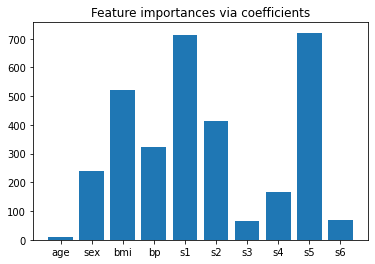

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import RidgeCV

ridge = RidgeCV(alphas=np.logspace(-6, 6, num=5)).fit(X, y)
importance = np.abs(ridge.coef_)
feature_names = np.array(diabetes.feature_names)
plt.bar(height=importance, x=feature_names)
plt.title("Feature importances via coefficients")
plt.show()

< 중요 피처 선택 >  
SelectFromModel()로 중요 피처를 선택한다.  
파라메터 threshold가 중요도 임계값이므로 이 값보다 큰 피처만 선택된다.  

In [15]:
from sklearn.feature_selection import SelectFromModel
from time import time

threshold = np.sort(importance)[-4] + 0.01

tic = time()
sfm = SelectFromModel(ridge, threshold=threshold).fit(X, y)
toc = time()
print(f"Features selected by SelectFromModel: {feature_names[sfm.get_support()]}")
print(f"Done in {toc - tic:.3f}s")

Features selected by SelectFromModel: ['bmi' 's1' 's5']
Done in 0.003s


< SelectFromModel 예제2>  
중요 피처 선택 알고리즘 LinearSVC 사용  

In [24]:
from sklearn.svm import LinearSVC
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectFromModel
X, y = load_iris(return_X_y=True)
X.shape

(150, 4)

In [21]:
lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(X, y)
model = SelectFromModel(lsvc, prefit=True)
X_new = model.transform(X)
X_new.shape

c:\users\playdata\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


(150, 3)

< SelectFromModel 예제3 >  
트리 기반 중요 피처 선택한다.  
덜 중요한 피처들을 트리에서 제거해 나가는 방법이다.  

In [25]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectFromModel
X, y = load_iris(return_X_y=True)
X.shape

(150, 4)

In [26]:
clf = ExtraTreesClassifier(n_estimators=50)
clf = clf.fit(X, y)
clf.feature_importances_  

array([0.06945002, 0.05816509, 0.42549741, 0.44688748])

In [27]:
model = SelectFromModel(clf, prefit=True)
X_new = model.transform(X)
X_new.shape       

(150, 2)

2) 피처 추출  
피처 선택은 중요하지 않은 피처를 제거하는 방법이지만 피처 추출은 피처간의 관계를 계산하여 피처의 수를 줄이는 방법이므로 데이터 손실을 막을 수 있다.  
  
- PCA(Principal component analysis)
  데이터 셋 여러 피처들간 상관관계를 계산하여 대표하는 주성분(Principal Compoment)을 추출해 차원을 축소하는 방법이다.  
  가장 높은 분산을 갖는 데이터의 축을 찾아 이 축으로 차원을 축소하고, 이 축에 직각이 되는 벡터로 차원을 축소하는 것을 반복하여 피처를 추린다. 

In [36]:
from sklearn.datasets import load_iris
import pandas as pd
import matplotlib.pyplot as plt

# 사이킷런 내장 데이터 셋 API 호출
iris = load_iris()

# 넘파이 데이터 셋을 Pandas DataFrame으로 변환
columns = ['sepal_length','sepal_width','petal_length','petal_width']
irisDF = pd.DataFrame(iris.data , columns=columns)
irisDF['target']=iris.target
irisDF.head(3)

,sepal_length,sepal_width,petal_length,petal_width,target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0


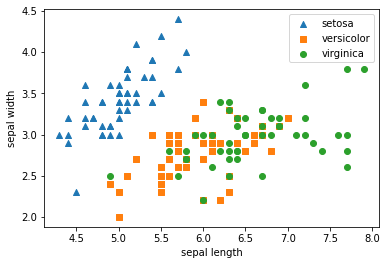

In [37]:
#setosa는 세모, versicolor는 네모, virginica는 동그라미로 표현
markers=['^', 's', 'o']

#setosa의 target 값은 0, versicolor는 1, virginica는 2. 각 target 별로 다른 shape으로 scatter plot 
for i, marker in enumerate(markers):
    x_axis_data = irisDF[irisDF['target']==i]['sepal_length']
    y_axis_data = irisDF[irisDF['target']==i]['sepal_width']
    plt.scatter(x_axis_data, y_axis_data, marker=marker,label=iris.target_names[i])

plt.legend()
plt.xlabel('sepal length')
plt.ylabel('sepal width')
plt.show()

In [38]:
from sklearn.preprocessing import StandardScaler

# Target 값을 제외한 모든 속성 값을 StandardScaler를 이용하여 표준 정규 분포를 가지는 값들로 변환
iris_scaled = StandardScaler().fit_transform(irisDF.iloc[:, :-1])

In [39]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

#fit( )과 transform( ) 을 호출하여 PCA 변환 데이터 반환
pca.fit(iris_scaled)
iris_pca = pca.transform(iris_scaled)
print(iris_pca.shape)

(150, 2)


In [40]:
# PCA 환된 데이터의 컬럼명을 각각 pca_component_1, pca_component_2로 명명
pca_columns=['pca_component_1','pca_component_2']
irisDF_pca = pd.DataFrame(iris_pca, columns=pca_columns)
irisDF_pca['target']=iris.target
irisDF_pca.head(3)

,pca_component_1,pca_component_2,target
0,-2.264703,0.480027,0
1,-2.080961,-0.674134,0
2,-2.364229,-0.341908,0


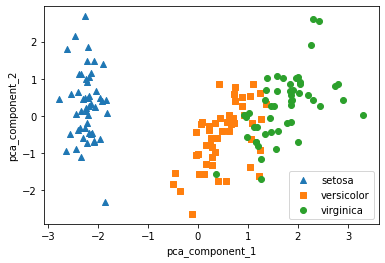

In [41]:
#setosa를 세모, versicolor를 네모, virginica를 동그라미로 표시
markers=['^', 's', 'o']

#pca_component_1 을 x축, pc_component_2를 y축으로 scatter plot 수행. 
for i, marker in enumerate(markers):
    x_axis_data = irisDF_pca[irisDF_pca['target']==i]['pca_component_1']
    y_axis_data = irisDF_pca[irisDF_pca['target']==i]['pca_component_2']
    plt.scatter(x_axis_data, y_axis_data, marker=marker,label=iris.target_names[i])

plt.legend()
plt.xlabel('pca_component_1')
plt.ylabel('pca_component_2')
plt.show()

In [42]:
print(pca.explained_variance_ratio_)

[0.72962445 0.22850762]


In [43]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import numpy as np

rcf = RandomForestClassifier(random_state=156)
scores = cross_val_score(rcf, iris.data, iris.target,scoring='accuracy',cv=3)
print('원본 데이터 교차 검증 개별 정확도:',scores)
print('원본 데이터 평균 정확도:', np.mean(scores))

원본 데이터 교차 검증 개별 정확도: [0.98 0.94 0.96]
원본 데이터 평균 정확도: 0.96


In [44]:
pca_X = irisDF_pca[['pca_component_1', 'pca_component_2']]
scores_pca = cross_val_score(rcf, pca_X, iris.target, scoring='accuracy', cv=3 )
print('PCA 변환 데이터 교차 검증 개별 정확도:',scores_pca)
print('PCA 변환 데이터 평균 정확도:', np.mean(scores_pca))

PCA 변환 데이터 교차 검증 개별 정확도: [0.88 0.88 0.88]
PCA 변환 데이터 평균 정확도: 0.88


- credit card 데이터 세트 PCA 변환

In [46]:
import pandas as pd

df = pd.read_excel('credit_card.xls', sheet_name='Data')
print(df.shape)
df.head(3)

(30001, 25)


,Unnamed: 0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X15,X16,X17,X18,X19,X20,X21,X22,X23,Y
0,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
1,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
2,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1


In [47]:
# header로 의미없는 첫행 제거, iloc로 기존 id 제거
import pandas as pd

df = pd.read_excel('credit_card.xls', header=1, sheet_name='Data').iloc[0:,1:]
print(df.shape)
df.head(3)

(30000, 24)


,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0


In [48]:
df.rename(columns={'PAY_0':'PAY_1','default payment next month':'default'}, inplace=True)
y_target = df['default']
X_features = df.drop('default', axis=1)

In [49]:
X_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 23 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   LIMIT_BAL  30000 non-null  int64
 1   SEX        30000 non-null  int64
 2   EDUCATION  30000 non-null  int64
 3   MARRIAGE   30000 non-null  int64
 4   AGE        30000 non-null  int64
 5   PAY_1      30000 non-null  int64
 6   PAY_2      30000 non-null  int64
 7   PAY_3      30000 non-null  int64
 8   PAY_4      30000 non-null  int64
 9   PAY_5      30000 non-null  int64
 10  PAY_6      30000 non-null  int64
 11  BILL_AMT1  30000 non-null  int64
 12  BILL_AMT2  30000 non-null  int64
 13  BILL_AMT3  30000 non-null  int64
 14  BILL_AMT4  30000 non-null  int64
 15  BILL_AMT5  30000 non-null  int64
 16  BILL_AMT6  30000 non-null  int64
 17  PAY_AMT1   30000 non-null  int64
 18  PAY_AMT2   30000 non-null  int64
 19  PAY_AMT3   30000 non-null  int64
 20  PAY_AMT4   30000 non-null  int64
 21  PAY_AMT5   3

<AxesSubplot:>

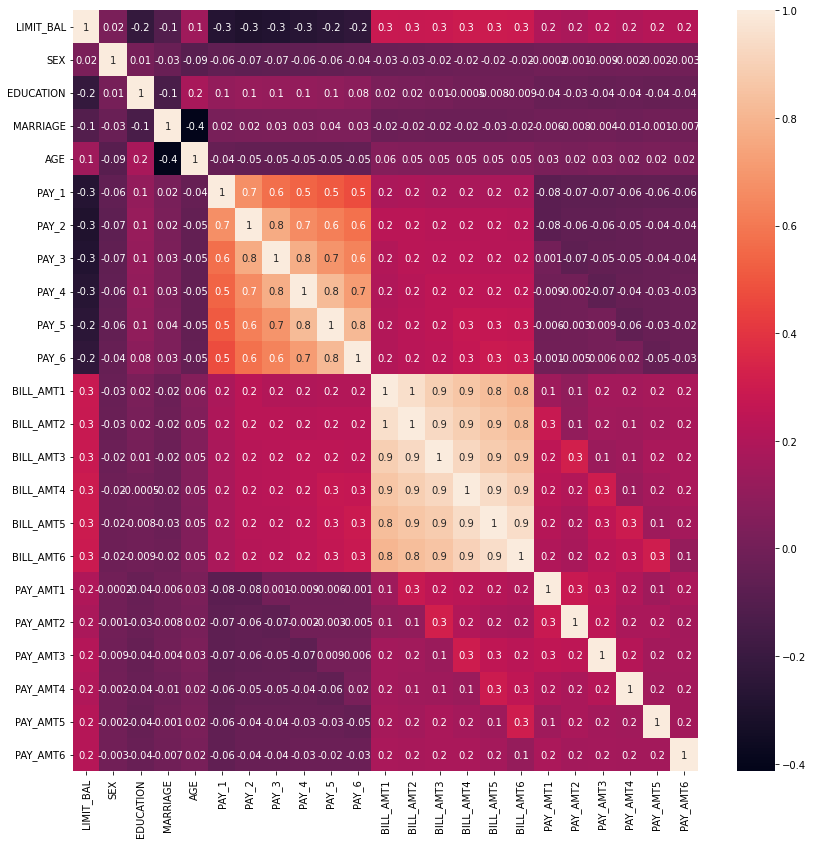

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = X_features.corr()
plt.figure(figsize=(14,14))
sns.heatmap(corr, annot=True, fmt='.1g')

In [51]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

#BILL_AMT1 ~ BILL_AMT6 까지 6개의 속성명 생성
cols_bill = ['BILL_AMT'+str(i) for i in range(1,7)]
cols_pay = ['PAY_' + str(i) for i in range(1, 7)]
cols_amt = ['PAY_AMT' + str(i) for i in range(1, 7)]
print(cols_bill)
cols_bill.extend(cols_pay)
cols_bill.extend(cols_amt)
print('대상 속성명:',cols_bill)

# 2개의 PCA 속성을 가진 PCA 객체 생성하고, explained_variance_ratio_ 계산 위해 fit( ) 호출
scaler = StandardScaler()
df_cols_scaled = scaler.fit_transform(X_features[cols_bill])
X_features.loc[:, cols_bill] = df_cols_scaled
pca = PCA(n_components=2)
pca.fit(df_cols_scaled)
print('PCA Component별 변동성:', pca.explained_variance_ratio_)

['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']
대상 속성명: ['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
PCA Component별 변동성: [0.36180187 0.20618472]


In [52]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

rcf = RandomForestClassifier(n_estimators=300, random_state=156)
scores = cross_val_score(rcf, X_features, y_target, scoring='accuracy', cv=3 )

print('CV=3 인 경우의 개별 Fold세트별 정확도:',scores)
print('평균 정확도:{0:.4f}'.format(np.mean(scores)))

CV=3 인 경우의 개별 Fold세트별 정확도: [0.8081 0.8197 0.8232]
평균 정확도:0.8170


In [53]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# 원본 데이터셋에 먼저 StandardScaler적용
scaler = StandardScaler()
df_scaled = scaler.fit_transform(X_features)

# 6개의 Component를 가진 PCA 변환을 수행하고 cross_val_score( )로 분류 예측 수행. 
pca = PCA(n_components=6)
df_pca = pca.fit_transform(df_scaled)
scores_pca = cross_val_score(rcf, df_pca, y_target, scoring='accuracy', cv=3)

print('CV=3 인 경우의 PCA 변환된 개별 Fold세트별 정확도:',scores_pca)
print('PCA 변환 데이터 셋 평균 정확도:{0:.4f}'.format(np.mean(scores_pca)))

CV=3 인 경우의 PCA 변환된 개별 Fold세트별 정확도: [0.7917 0.7971 0.801 ]
PCA 변환 데이터 셋 평균 정확도:0.7966
